In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sequential_sampler import SMCSampler1

import torch
from torch.distributions import MultivariateNormal

In [3]:
N = 10000
x0 = torch.randn(N,1)
w0 = torch.ones(N)/N
T = 30
target_log_densities = [MultivariateNormal(torch.tensor([float(i)]), torch.eye(1)).log_prob for i in range(T)]
smc = SMCSampler1(target_log_densities, x0, w0)

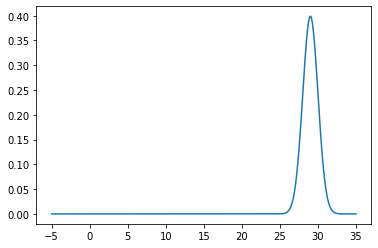

In [4]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
linspace= torch.linspace(-5, 35,1000).unsqueeze(-1)
for i in range(T):
    clear_output(wait=True)
    plt.figure()
    plt.plot(linspace, torch.exp(target_log_densities[i](linspace)))
    plt.show()

In [5]:
smc.sample()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:30<00:00,  3.12s/it]


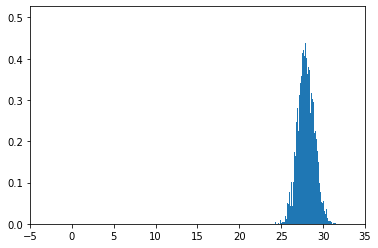

In [6]:
for particle_set in smc.particles:
    clear_output(wait=True)
    plt.figure()
    plt.hist(particle_set.detach().numpy(), bins= 100, density = True)
    plt.xlim((-5,35))
    plt.show()

In [7]:
from targets.variational_inference_target import * 

In [41]:
T = 10
target = Dimension1()

In [42]:
target_log_densities = []
for i in range(T):
    temp = lambda samples : (1-i/(T-1))*MultivariateNormal(torch.zeros(1), torch.eye(1)).log_prob(samples) + i/(T-1)*target.log_prob(samples)
    target_log_densities.append(temp)

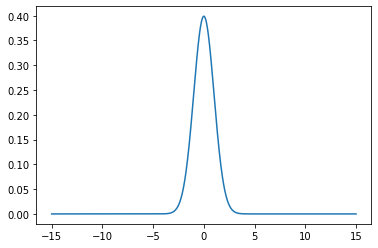

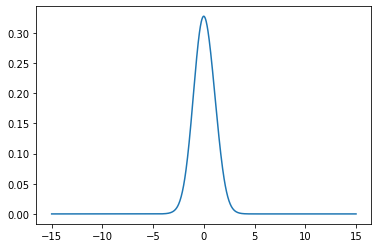

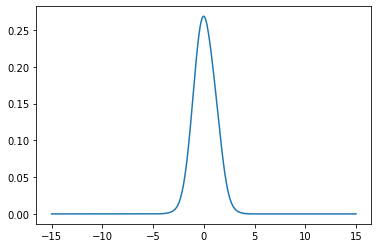

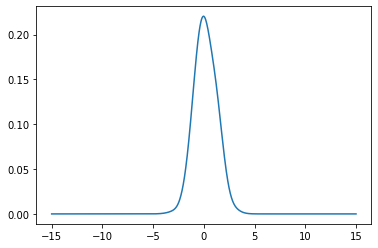

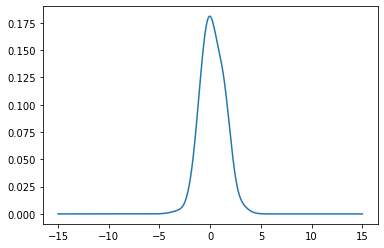

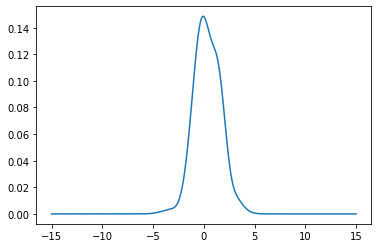

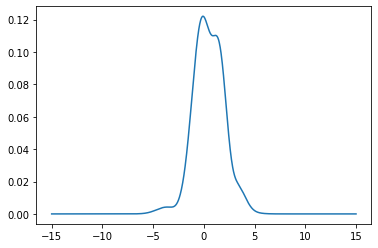

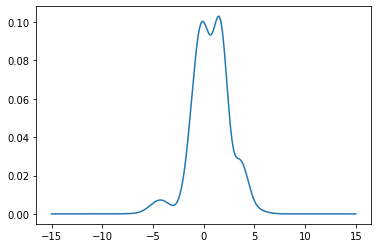

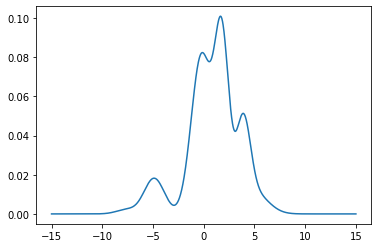

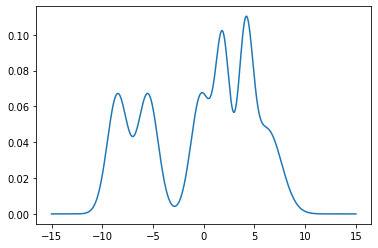

In [43]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
linspace= torch.linspace(-15, 15,1000).unsqueeze(-1)
for i in range(T):
    #clear_output(wait=True)
    plt.figure()
    plt.plot(linspace, torch.exp(target_log_densities[i](linspace)))
    plt.show()

In [44]:
smc = SMCSampler1(target_log_densities, x0, w0)
smc.sample()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.73s/it]


torch.Size([10000, 1])


ValueError: weights should have the same shape as x

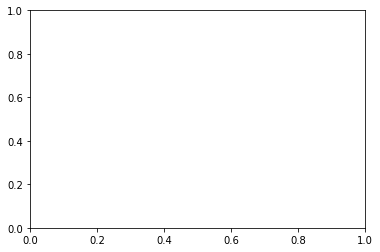

In [49]:
for i,particle_set in enumerate(smc.particles):
    #clear_output(wait=True)
    plt.figure()
    print(smc.particles[i].shape)
    plt.hist(particle_set.squeeze(-1).detach().numpy(), bins= 100, density = True, weights = smc.weights[i])
    linspace= torch.linspace(-15, 15,1000).unsqueeze(-1)
    plt.plot(linspace, torch.exp(target_log_densities[i](linspace)))
    plt.xlim((-15,15))
    plt.show()

In [78]:
from posterior_sampler import MALA
mala_sampler = MALA(target.log_prob, .1,1)
samples = mala_sampler.sample(20000,1000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21000/21000 [00:46<00:00, 451.24it/s]


(array([  1.,   9.,  10.,  19.,  34.,  65.,  99., 140., 160., 199., 270.,
        297., 318., 317., 317., 290., 229., 213., 204., 198., 207., 230.,
        253., 286., 294., 298., 297., 276., 225., 137., 101.,  60.,  36.,
         37.,  27.,  26.,  20.,  24.,  35.,  80., 123., 177., 202., 215.,
        295., 312., 323., 297., 247., 302., 322., 371., 408., 437., 532.,
        496., 490., 359., 325., 260., 317., 347., 460., 544., 546., 509.,
        481., 419., 339., 287., 244., 243., 263., 246., 251., 239., 262.,
        247., 182., 163., 109., 102.,  85.,  58.,  54.,  30.,  25.,  24.,
         26.,  23.,  11.,  10.,   8.,   4.,   4.,   3.,   2.,   1.,   1.,
          1.]),
 array([-11.558935  , -11.315328  , -11.07172   , -10.828113  ,
        -10.584505  , -10.340898  , -10.09729   ,  -9.8536825 ,
         -9.610075  ,  -9.366467  ,  -9.12286   ,  -8.879252  ,
         -8.635645  ,  -8.392037  ,  -8.14843   ,  -7.904822  ,
         -7.6612144 ,  -7.417607  ,  -7.1739993 ,  -6.930392  

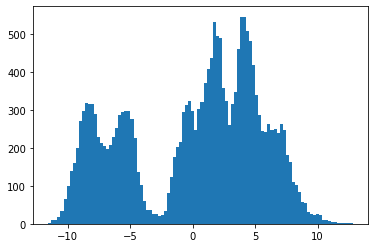

In [79]:
plt.hist(samples.detach().numpy(), bins = 100)